<a href="https://colab.research.google.com/github/TemsyChen/DS-Unit-2-Kaggle-Challenge/blob/master/TemsyChen_DS_module_project_221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [55]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

# Decision Trees

## Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website (the URL is in Slack). Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.

## Wrangle Data

**Task 2:** Add to the code below so that `id` is set as the index for `df`.

In [56]:
import pandas as pd

df = pd.merge(pd.read_csv(DATA_PATH + 'waterpumps/train_features.csv'),
              pd.read_csv(DATA_PATH + 'waterpumps/train_labels.csv'))
df = df.set_index('id')

df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


**Test 2**

In [57]:
'''Task 2 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created the DataFrame `df`?'
assert df.shape == (59400, 40), '`df` is the wrong shape. Did you set the index to `id`?'
assert 69572 in df.index, 'The index for `df` is has the wrong values. Did you set the index to `id`?'

In [58]:
df.shape

(59400, 40)

## Split Data

**Task 3:** Create your target vector `y` and feature matrix `X`.

In [59]:
target = 'status_group'
features = df.columns[df.columns!='status_group'].to_list()
print(features)

X = df[features]
y = df[target]

['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


**Test 3**

In [60]:
'''Task 3 Testing'''

assert isinstance(X, pd.DataFrame), '`X` is the wrong data type.'
assert isinstance(y, pd.Series), '`y` is the wrong data type.'
assert y.shape == (59400,), '`y` is the wrong shape.'
assert X.shape == (59400,39), '`X` is the wrong shape.'

In [61]:
X.shape, y.shape

((59400, 39), (59400,))

We already have a test set for this model, the `test.csv` that you'll use to make the predictions you'll upload to Kaggle. However, since our competition only allows for 2 submissions per day, we need a way to estimate our training error so that we can quickly iterate and improve our model. We can achieve this by creating a validation set from the data we have.

**Task 4:** Split `X` and `y` into training and validation sets. Your validation set should be 20% of the data you have. You should have four variables: `X_train`, `X_val`, `y_train`, and `y_val`. 

In [62]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df['status_group'], random_state=37)

#check shape
train.shape, val.shape

((47520, 40), (11880, 40))

In [63]:
#Arrange X matrices and y vectors

X_train = train[features]
X_val = val[features]
y_train = train[target]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((47520, 39), (47520,), (11880, 39), (11880,))

**Test 4**

In [64]:
'''Task 4 Testing'''

assert X_train.shape == (47520, 39), '`X_train` is the wrong shape.'
assert X_val.shape == (11880, 39), '`X_val` is the wrong shape.'
assert y_train.shape == (47520,), '`y_train` is the wrong shape.'
assert y_val.shape == (11880,), '`y_val` is the wrong shape.'

## Establish Baseline

**Task 5:** This is a **classification** problem, so you need to establish the baseline accuracy for your training set. Find the majority class for `y_train` and calculate the percentage of labels in `y_train` belonging to that class. Assign your answer to the variable name `baseline_acc`.

In [65]:
print(y_train.value_counts(normalize=True))
baseline_acc = y_train.value_counts(normalize=True)[0]
print('Baseline Accuracy:', baseline_acc)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64
Baseline Accuracy: 0.5430765993265994


**Task 5**

In [66]:
'''Task 5 Testing'''

assert isinstance(baseline_acc, float), '`baseline_acc` should be a `float`.'
assert 0.0 <= baseline_acc <= 1.0, '`baseline_acc` is a score that should be between 0 and 1.'

###Data Exploration

In [67]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True)

profile

In [68]:
train['latitude'].value_counts()

-2.000000e-08    1453
-6.978263e+00       2
-7.065373e+00       2
-6.975052e+00       2
-7.177203e+00       2
                 ... 
-3.959266e+00       1
-7.540756e+00       1
-1.027087e+01       1
-3.599990e+00       1
-8.855910e+00       1
Name: latitude, Length: 46023, dtype: int64

In [69]:
train['longitude'].value_counts()

0.000000     1453
32.987670       2
37.541579       2
37.339811       2
37.252194       2
             ... 
37.419696       1
38.180325       1
33.892953       1
35.480778       1
35.711064       1
Name: longitude, Length: 46022, dtype: int64

In [70]:
#Define a function to wrangle the training data and validation data

import numpy as np

def wrangle(X):
  X = X.copy() #to prevent SettingwithCopyWarning

  #in latitude there are 1453 values of -2.0e-8
  #convert them to 0 
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #replace the zeros in latitude and longitude to NaN
  zero_cols = ['latitude', 'longitude']
  for col in zero_cols:
    X[col] = X[col].replace(0, np.nan)

  #drop quantity group, since it's a duplicate of quantity, 
  #and other features that don't seem useful: recorded_by, num_private, construction year
  X = X.drop(columns=['quantity_group','recorded_by','num_private','construction_year'])

  return X

X_train = wrangle(X_train)
X_val = wrangle(X_val)

In [71]:
#Reduce features by removing high cardinality columns

#get a series with the cardinality of the nonnumeric features
cardinality = X_train.select_dtypes(exclude='number').nunique()

#get a list of categorical features where cardinality <=50
categorical_features = cardinality[cardinality <= 50].index.tolist()

#get a list of numeric features
numeric_features = X_train.select_dtypes(include='number').columns.tolist()

#combine numeric and low-cardinality features
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [72]:
#put in new features to the X matrices

X_train = X_train[features]
X_val = X_val[features]

In [73]:
#check shape of X matrices
X_train.shape, X_val.shape

((47520, 27), (11880, 27))

## Build Model

**Task 6:** Create a model named `model` and train it with your training data. Your model should be a pipeline with (a) transformers that you think are appropriate to this dataset and (b) a `DecisionTreeClassifier` as your predictor. **Tip:** How can you transform categorical features and missing values in order to train your model?

In [76]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce

model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    DecisionTreeClassifier(random_state=37)
)

model.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Test 6**

In [77]:
'''Task 6 Testing'''

assert len(model) > 1, 'Your model pipeline should have multiple steps.'
assert isinstance(model[-1], DecisionTreeClassifier), 'Your pipline should end in a `DecisionTreeClassifier`.'
assert hasattr(model, 'classes_'), 'Have you fit your model?'

## Check Metrics

**Task 7:** Calculate the training and validation accuracy of your model, and assign them to the valiables `training_acc` and `validation_acc`, respectively. Your validation accuracy should be greater than your baseline accuracy.

In [79]:
training_acc = model.score(X_train, y_train)
validation_acc = model.score(X_val, y_val)

print('Training Accuracy:', training_acc)
print('Validation Accuracy:', validation_acc)

Training Accuracy: 0.9952230639730639
Validation Accuracy: 0.7573232323232323


In [91]:
#Improve the model by reducing model complexity

model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=37)
)

model.fit(X_train, y_train)

#get the train and validation accuracy scores
training_acc = model.score(X_train, y_train)
validation_acc = model.score(X_val, y_val)

print('Training Accuracy:', training_acc)
print('Validation Accuracy:', validation_acc)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training Accuracy: 0.8073442760942761
Validation Accuracy: 0.7738215488215489


**Test 7**

In [92]:
'''Task 7 Testing'''

assert isinstance(training_acc, float)
assert isinstance(validation_acc, float)
assert 0.0 <= training_acc <= 1.0
assert 0.0 <= validation_acc <= 1.0

## Create Kaggle Submission

**Task 8:** Load `'waterpumps/test.csv'` into a DataFrame named `X_test`. Generate a list of predictions, and then put them into a DataFrame `submission`. Be sure that `submission` has the same index as `X_test` and that the column name for your predictions is `'status_group'`.  

In [131]:
X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id')

X_test.shape

(14358, 39)

In [132]:
#Wrangle the test data
X_test = wrangle(X_test)

#reduce features for the test data
X_test = X_test[features]

X_test.shape

(14358, 27)

In [133]:
#Make a prediction
y_pred = model.predict(X_test)
y_pred

array(['functional', 'functional', 'functional', ..., 'non functional',
       'functional', 'non functional'], dtype=object)

**Test 8**

In [118]:
'''Task 8 Testing'''

assert isinstance(submission, pd.DataFrame), '`submission` should be a DataFrame.'
assert len(submission) == 14358, '`submission` should have 14358 rows.'

**Task 9 (`stretch goal`):** Save `submission` as a csv file using [`.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and submit it to our Kaggle competition.

In [134]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Temsy_Chen_2.csv', index=False)

In [135]:
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [138]:
from google.colab import files
uploaded = files.upload()

Saving Temsy_Chen_2.csv to Temsy_Chen_2 (1).csv


In [140]:
df = pd.read_csv('Temsy_Chen_2 (1).csv')
df

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,non functional
14356,33492,functional


## Explain

**Task 10 (`stretch goal`):** Make a horizontal barchart of the 10 most important features for your model.

In [145]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=37)
)

pipeline.fit(X_train, y_train)

#get the train and validation accuracy scores
training_acc = pipeline.score(X_train, y_train)
validation_acc = pipeline.score(X_val, y_val)

print('Training Accuracy:', training_acc)
print('Validation Accuracy:', validation_acc)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Training Accuracy: 0.8073442760942761
Validation Accuracy: 0.7738215488215489


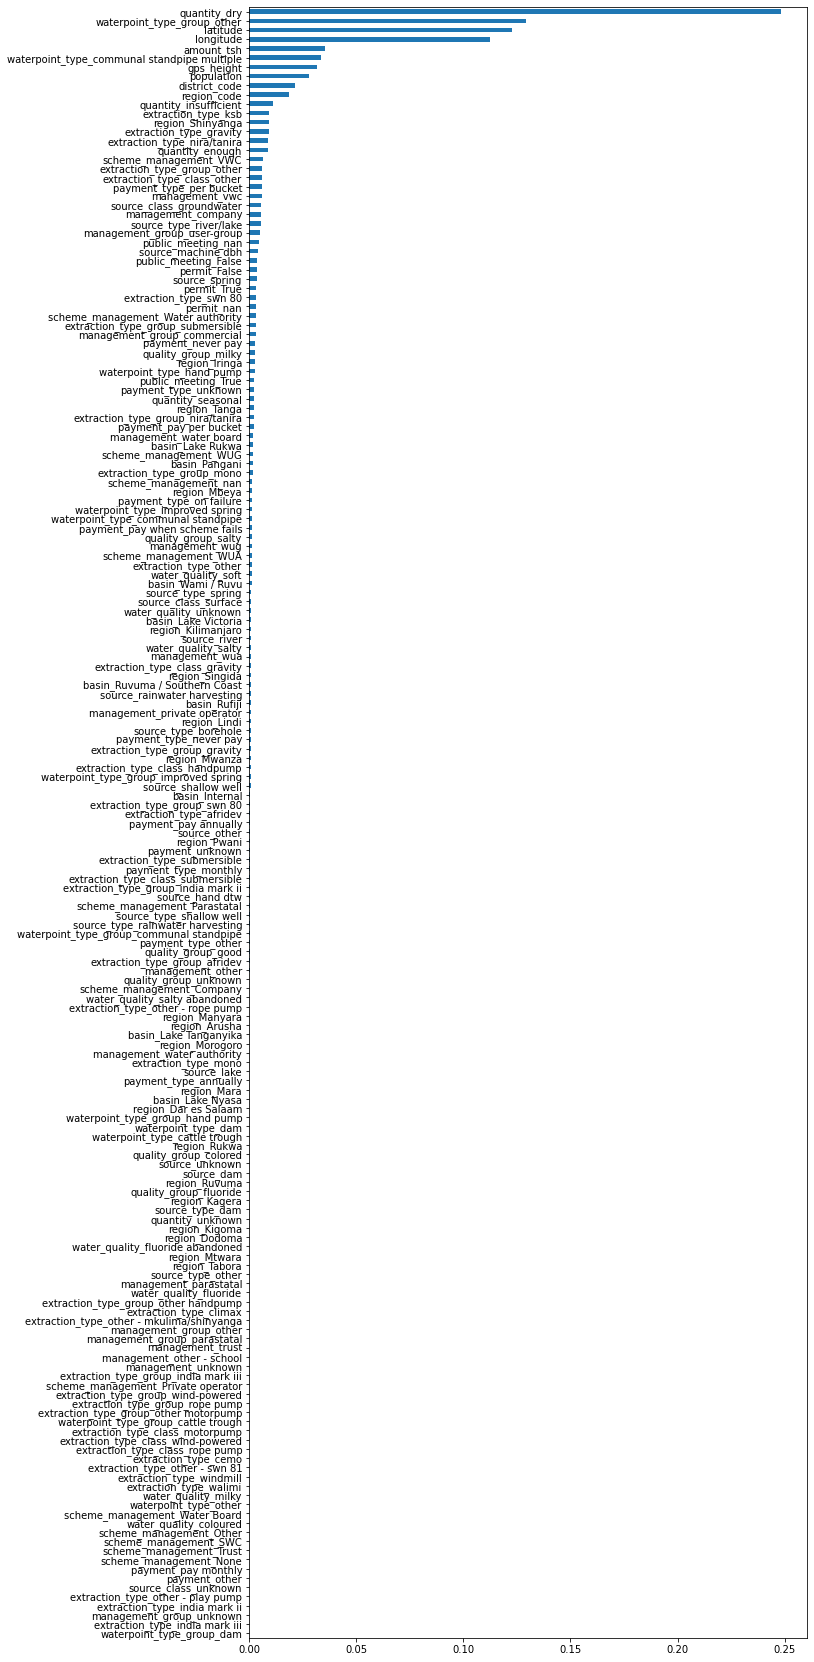

In [148]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()